<a href="https://colab.research.google.com/github/StevenPeutz/Disinformation-NLP/blob/master/DATA/Compile_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Compilation.

This Notebook contains the code to import six datasets containing either disinformation, misinformation fake news or propaganda, true news articles or other non-false texts, or a combination of these.  

While this study has a focus on politically motivated disinformation (i.e the bulk of texts are deliberately misleading or false statement with certain political goals), texts that are false or misleading without deliberate intent are also included to more closely mimic the the variety encoutered on e.g. social media platforms in real life).  
<br>

<b>Dataset compilation (section 1 - 3):</b> 

Compiling different datasets as done in this study requires carefull formatting to make sure all sets can be combined as one. Sections 1 - 3 read in to the six datasets from csv, create a consistent format, drop duplicates and combine them into a single consistent +73k dataset.  
<br> 

| Name                          | Rows   | Size (gzipped) | Storage | Download link (use raw version if directly in notebook)                                                   |
| -----------------------------|-------|----------------|---------| -------------------------------------------------------------------------------------------------------------|
| fake_train                    | 20.387| 38.4MB         | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/21k_Chendra/fake_train.csv.gz |
| fake_or_real_news             | 6.060 | 11.9MB         | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/6k_Jillani/fake_or_real_news.csv.gz |
| data                          | 6.241 | 4.7MB          | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/EUvsDisinfo.eu/data.csv.gz |
| monkeypox                     | 4.000 | 7.8MB          | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/MonkeyPoxMisinfo/monkeypox.csv.gz |
| Fake                          | 20.000| 23.7MB         | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/UVIC-ISOT/Fake.csv.gz |
| True                          | 20.000| 18.7MB         | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/UVIC-ISOT/True.csv.gz |
| CompiledDisinfo_74k<sup>1  </sup>          | 73.900| 75.1MB         | Github  | https://github.com/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/DATA/CompiledDisinfo_74k/CompiledDisinfo_74k.csv.gz | 
<br>

<sup>1  </sup> *'CompiledDisinfo_74K' is not a seperately sourced dataset, but is the compiled version of the above 6 datasets. This can be directly downloaded form the given link).*

<br><br>


<b>Minimal cleaning (section 4):</b>  
In order to keep our texts as close to the raw data as possible, we will limit ourselves to only manipulating substrings that can be directly used by the model to differentiate disinformation from true articles due to a lack in representivity in true/false sets (e.g. the "reuters" prefix that is common in true labeled articles scraped from reuters.). 
<br><br>
<b>EDA  (section 7):</b>  
While not the focus of this study, I have added a quick simple EDA by creating the most obvious but practically interesting linguistic features to get a rough understanding of linguistic/stylistic differences between disinformation and regular articles (e.g. average sentence lengths, number of hyperlinks, hashtag usage, stopword counts etc).
<br><br>
<b>Prepping for translation  (section 8-10):</b>  
This study needed a 30% test set (referred to as testN0) and a backtranslated version of that exact testset (testN1) and another backtranslated version of that one (now called testN2) until 'testN3'. This would allow me to compare diffent architectures on their AUC decay as noise increases due the the backtranslation inaccuracies.
Secondly, text were xut short to 2800 characters as google translate would sporadically block backtranslation of texts around 3000 characters and above (while messaging that 3900 characters was the limit).
<br><br>
<b>Three levels of Backtranslation using gooogle translate API (section 11):</b>  
Google translate was chosen for this, as this is the machine translation service worldwide, especially for relatively short texts that are typical on social media. Given the size of our dataset a batching system (a total of 50 splits) had to created in order to prevent timeouts by google translate. The test set to be used later is exported to google drive storage (as csv) in section 12.  This finalized testset can also be found directly in this github)  
<br>
<br>
<br>



---



---



# 0. Imports and GDrive connection ('mounting')

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as pyplot

In [ ]:
from wordcloud import STOPWORDS
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
#nltk (for stemming)
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive')
#uncomment the above to allow exports to google drive. This is not a requirement in this version.

Mounted at /content/drive


In [ ]:
!pip install googletrans==3.1.0a0
# version hardcoded because of an error in the latest version..
from googletrans import Translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 6.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=271102e9e775ac19832d5f650cb10aa0fbb1cda7c8de211a13283acb9d479d52
  Stored in directory: /root/.cache/pip/wheels/ae/e1/6c/5137bc3f35aa130deea71575e165cc4f4f0680a88f3d90a636
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
 

# 1. Reading in the datasets (true & false)

In [ ]:
#datasets with political disinfo, fake news and regular news
path1 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/UVIC-ISOT/Fake.csv.gz' #FAKE  University of Victoria #ISOT Ahmed H, Traore I, Saad S.  UVIC-ISOT
path2 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/21k_Chendra/fake_train.csv.gz' #FAKE&TRUE  #20k dataset without further description
path3 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/6k_Jillani/fake_or_real_news.csv.gz'#FAKE&TRUE  #same as RALUCACHITIC set, 6060 balanced.
path4 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/EUvsDisinfo.eu/data.csv.gz' #FAKE  #EUvsDisinfo dataset (scraped) 2016-2020 6k
path5 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/UVIC-ISOT/True.csv.gz' #TRUE. #ISOT Ahmed H, Traore I, Saad S. dataset of ±21k UVIC-ISOT

#--- extra: chinese covid (dis)info ('CHECKED-project):
path6 = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/MonkeyPoxMisinfo/monkeypox.csv.gz' #mixed twitter, monkeypox (factchecked)


In [ ]:
#the fake/true nomenclature here describes the set to be, not the current status (i.e. fake and true mixed sets are named both true and fake at this stage)

#fake:
df_fake1 = pd.read_csv(path1, compression='gzip')
df_fake2 = pd.read_csv(path4, compression='gzip')
#true:
df_true1 = pd.read_csv(path5, compression='gzip')
#mixed:
df_mixed1 = pd.read_csv(path2, compression='gzip')
df_mixed2 = pd.read_csv(path3, compression='gzip')
df_mixed3 = pd.read_csv(path6, compression='gzip')

#df_mixed_copies (needed for formatting function for now)
df_mixed1B = pd.read_csv(path2, compression='gzip')
df_mixed2B = pd.read_csv(path3, compression='gzip')
df_mixed3B = pd.read_csv(path6, compression='gzip')

In [ ]:
print('fake1 shape: {}'.format(df_fake1.shape)) # 23.481, 4
print('fake2 shape: {}'.format(df_fake2.shape)) # 7.369, 36

print('true1 shape: {}'.format(df_true1.shape)) # 21.417, 4

print('mixed1 shape: {}'.format(df_mixed1.shape)) # 20.800,5
print('mixed2 shape: {}'.format(df_mixed2.shape)) # 6.335, 4
print('mixed3 shape: {}'.format(df_mixed3.shape)) # 5.787, 19

fake1 shape: (23481, 4)
fake2 shape: (7369, 37)
true1 shape: (21417, 4)
mixed1 shape: (20800, 5)
mixed2 shape: (6335, 4)
mixed3 shape: (5787, 19)


In [ ]:
#one manual tweak for dataset 4 needed for the function to work on all 4
df_fake2.drop('text', axis=1, inplace = True)
df_fake2.rename(columns = {'claim_reviewed':'text'}, inplace = True)
df_mixed3.rename(columns = {'binary_class':'label'}, inplace = True)
df_mixed3B.rename(columns = {'binary_class':'label'}, inplace = True)

# 2. One format for all dataset




Let's start without reading the files (so no loop needed yet) and just doing the removal of empties and deduplication. TO be exact:


1.   drop rows that have labels for non corresponding truth value (so that we have truth and false seperates prior to joining)
2.   drop each column that is not the text column
3.   drop all empties (including 'fake empties')
4.   drop duplicates
5.   add label column
6.   return the 'new' dataset.





In [ ]:
def removeEmpties_Deduplicate(x,tf_num, tf_term):
  ''' trying a function to do the repetitive work
  purpose:
  This function is to deduplicate as well as separate true from false in the labeled datasets that are our source data.
  This allows me to use a single function on the 7 difference datasources used, and have deduplicated and compatible dataframes as output
  seperated for true and false values. To be combined to the single overal dataset after further cleaning.
  input:
  x : the dataframe to work with
  tf_nm : truth/false numerical, 0 for the 'true' labels, 1 for the disinfo labels.
  tf_term : truth/false in terms, 'TRUE' for the 'true' labels, 'FAKE' for the disinfo labels.
  output:
  dataframe x
  '''
  #remove the unwanted rows (true or fake) depending on set (based on label value == 0 or 1 under tf_num variable)
  #doing the same with those were true or false is code in text ('REAL' or 'FAKE', with tf_term)
  try:
    x.drop(x.index[x['label'] == tf_num], inplace=True)
    x.drop(x.index[x['label'] == tf_term], inplace=True)
  
    
    #x.rename(columns = {'claim_reviewed':'text'}, inplace = True). #not possible in combination with try except (and double 'text' column names..)
  except:
    print('(step to be skipped as the change is not needed for this dataset)')
  finally:
    #remove unneeded colums (so as filter..)
    columnkeeper = ['text']
    x = x.drop(x.columns.difference(columnkeeper), axis=1)
    #replace space empties with recognized empties, then drop all empties
    x['text'].replace(' ', np.nan, inplace=True)
    x.dropna(
      axis=0,
      how='any',
      subset=None,
      inplace=True)
    #remove duplicates with pandas function
    x = x.drop_duplicates(subset=["text"], keep='first')
    #add column with true of false statement (1- value to reverse code..)
    x['label'] = (1-tf_num)
    print(' > This dataset has shape:{}'.format(x.shape))
    return x 

## Applying the formatting function on all sets:




In [ ]:
DatasetList_FAKEandMIXED = [df_fake1, df_fake2, df_mixed1, df_mixed2, df_mixed3]
DatasetList_TRUEandMIXED = [df_true1, df_mixed1B, df_mixed2B, df_mixed3B]
#one list is also possible without any changes needed.. but not this is better for readability

List_DataSets = []
#List_TRUE =[]

#disinformation sets:
print('--- Running the prep function on the disinfo + mixed sets:')
for i in DatasetList_FAKEandMIXED:
   List_DataSets.append(removeEmpties_Deduplicate(i, 0, 'REAL' ))
   #DROPPING rows with value 0 or 'real', to retain only disinfo.

#true news/info sets:
print('--- Running the prep function on the true + mixed sets:')
for i in DatasetList_TRUEandMIXED:
  List_DataSets.append(removeEmpties_Deduplicate(i, 1, 'FAKE' ))
   #DROPPING rows with value 1 or 'fake', to retain only true.


#QUESTION: check if there arent rows that are not dropped that should be dropped in the above..
print('--- cleaning, now running through shape of all list objects (df) ---')  

--- Running the prep function on the disinfo + mixed sets:
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(17454, 2)
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(6043, 2)
 > This dataset has shape:(9998, 2)
 > This dataset has shape:(3070, 2)
 > This dataset has shape:(1035, 2)
--- Running the prep function on the true + mixed sets:
(step to be skipped as the change is not needed for this dataset)
 > This dataset has shape:(21191, 2)
 > This dataset has shape:(10387, 2)
 > This dataset has shape:(2989, 2)
 > This dataset has shape:(4231, 2)
--- cleaning, now running through shape of all list objects (df) ---


# 3. Combine all dataframes into one labeled dataframe.

*   combine ('union' in SQL terms, 'concat' in python)
*   trim trailing and starting whitespace (just to be safe)
*   drop duplicates (as after union new duplicates are possible)




In [ ]:
#creating a 'union' of all the dataframes (concat)
df_unionedlist = pd.concat(List_DataSets, ignore_index=True)

#trimming before checking for duplicates (this helps us find 2486 dupes instead of 2473)
df_unionedlist['text'] = df_unionedlist['text'].str.strip()

In [ ]:
#checking for empties in the text column.
df_unionedlist['text'].isna().sum() #after function, all are zero :)
#repeat this after removing suffixes and prefixes!

0

In [ ]:
dupes = df_unionedlist[df_unionedlist.duplicated(subset = 'text', keep = 'first')]
dupes.shape #2487 duplicates
#having done the trimming before checking for duplicates helped us find 2487 dupes instead of 2475

(2487, 2)

In [ ]:
#dropping the dupes found above (if correctly done, there should be 71132-2487= 68645 unique rows left)
df_unionedlist.drop_duplicates(subset='text', keep='first', inplace=True) # ignore_index=False)
df_unionedlist.shape

(73911, 2)

# 4. Removing the source prefixes and other suffixes

(e.g. 'photo by... Feature.. and 'WASHINGTON (Reuters)..)


In [ ]:
#make a working copy of the df before making changes to the data
df_full = df_unionedlist

In [ ]:
#removing all the suffixes by deleting everything right of ' Photo by.. '
#df_unionof4sets['text'] = df_unionof4sets['text'].str.split('Photo by'|'Featured image').str[0]
df_full['text'] = df_full['text'].apply(lambda x: re.split(r'Photo by|Featured image', x)[0])

In [ ]:
#df_unionof3sets['text'] = df_unionof3sets['text'].apply(lambda x: re.split(r'WASHINGTON \(Reuters\) - |WEST PALM BEACH, Fla \(Reuters\) - ', x)[-1])
df_full['text'] = df_full['text'].apply(lambda x: re.split(r' - |\(CNN\)', x)[-1])

In [ ]:
#this can be done better (like with a list od city names followed by a ' - '.. instead of only washsington or somehting)
#another option woould be to delete everything before the - IF the - is within the first 20 chars of the doc..

df_full.sample(5)

,text,label
68377,It’s raining in California. Again. A storm sys...,0
4738,Billionaire Mark Cuban had previously been roo...,1
33067,FBI Agents Must Come Forward to Confront Corru...,1
17122,Tune in to the Alternate Current Radio Network...,1
44504,U.S. President-elect Donald Trump said he expe...,0


# 5. Exporting (& importing) to csv (optional)
- name: CompiledDisinfo_74k.csv
- Location: MyDrive/MYDATA

In [ ]:
#df_full.to_csv(r'/content/drive/MyDrive/MYDATA/CompiledDisinfo_74k.csv')
#uncomment the above to export the compiled dataset to google drive.

 **5B. Importing stored csv + balance check**

- after having saved the raw file as csv, we will read it in anew.
This helps us in troubleshooting later, and makes it easier to make changes later on without breaking the code.
- check (again) for empties + remove empties
- check balance of dataset (count 0's and 1's)

In [ ]:
'''
path_to_compiled_dataset_on_drive = '/content/drive/MyDrive/MYDATA/CompiledDisinfo_74k.csv'
df_full = pd.read_csv(path_to_compiled_dataset_on_drive, index_col=[0])
'''
#uncomment the above to read in from drive

#or read in from github (this is just a backup option, not needed to continue):
"""
path_to_compiled_dataset_on_gh = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/CompiledDisinfo_74k/CompiledDisinfo_74k.csv.gz'
df_full= pd.read_csv(path_to_compiled_dataset_on_gh, index_col=[0], compression='gzip')
"""

"\npath_to_compiled_dataset_on_gh = 'https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/CompiledDisinfo_74k/CompiledDisinfo_74k.csv.gz'\ndf_full= pd.read_csv(path_to_compiled_dataset_on_gh, index_col=[0], compression='gzip')\n"

In [ ]:
#repeat the check for empties, as here suffixes and prefixes have been deleted..
df_full['text'].isna().sum()

14

In [ ]:
df_full.dropna(
      axis=0,
      how='any',
      subset=None,
      inplace=True)

In [ ]:
#calculate balance of dataset 
news = df_full['label'].value_counts()[0]
disinfo = df_full['label'].value_counts()[1]

disinfoPercent = ((disinfo/(disinfo+news))*100)
'disinfo precentage of total dataset is {number:.{digits}f}%'.format(number=disinfoPercent, digits=2)

'disinfo precentage of total dataset is 47.50%'

In [ ]:
print('there are {} rows of real news'.format(df_full['label'].value_counts()[0]))
print('and {} rows of disinfo'.format(df_full['label'].value_counts()[1]))

there are 38797 rows of real news
and 35100 rows of disinfo


# 7. EDA (preliminary)

//EDA, not needed for rest of code


## Feature egineering
- ToDo: use percentages instead of raw *counts*

In [ ]:
#make copy of dataset
df_full_EDA = df_full

# word_count
df_full_EDA['word_count'] = df_full_EDA['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_full_EDA['unique_word_count'] = df_full_EDA['text'].apply(lambda x: len(set(str(x).split())))

In [ ]:
df_full_EDA['stop_word_count'] = df_full_EDA['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [ ]:
# punctuation_count.  # not working, string.punctuation is giving problems
#df_full_EDA['punctuation_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [ ]:
# mean_word_length
df_full_EDA['mean_word_length'] = df_full_EDA['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
# url_count
df_full_EDA['url_count'] = df_full_EDA['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [ ]:
# hashtag_count
df_full_EDA['hashtag_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [ ]:
# mention_count
df_full_EDA['mention_count'] = df_full_EDA['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

## Plotting the created features (viz) + conclusion about dataset
- ToDo: see 'feature egineering'
- TODo: all vizuals in a grid

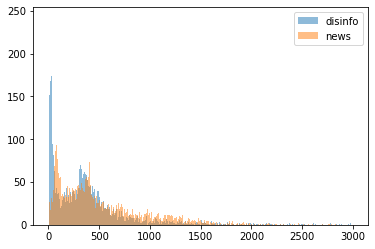

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'word_count']

bins=list(range(3000))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

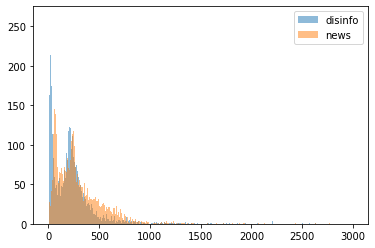

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'unique_word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'unique_word_count']

#bins=list(range(3000))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

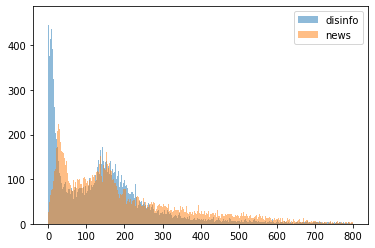

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'stop_word_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'stop_word_count']

bins=list(range(800))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

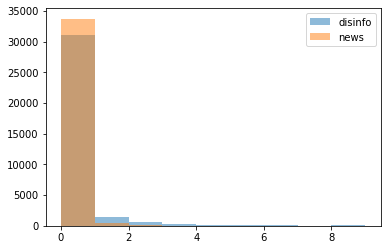

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'hashtag_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'hashtag_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

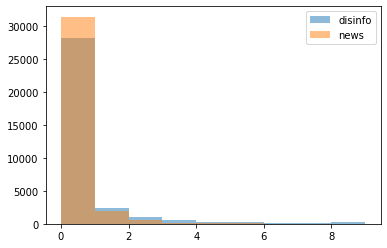

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'mention_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'mention_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

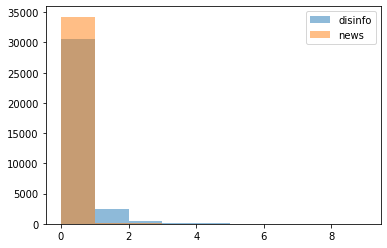

In [ ]:
x=df_full_EDA.loc[df_full_EDA['label']==1, 'url_count']
y=df_full_EDA.loc[df_full_EDA['label']==0, 'url_count']

bins=list(range(10))

pyplot.hist(x, bins, alpha=0.5, label='disinfo')
pyplot.hist(y, bins, alpha=0.5, label='news')
pyplot.legend(loc='upper right')
pyplot.show()

Preliminary (eyeballed) conclusions:
- disinfo texts are mote likely to have @mentions, urls and hasthtags.
- extremely short texts are more likely to be disinfo
- These conclusions are more likely to be a dataset problem more than a real inference about news vs disinfo..

ToDo:
- see above (bulletpoint 3)
- for e.g. stopword count, make it stopwordcount as ratio of total word count. etc
- put in grid
- get data that is not 'news', but non disinfo texts not written by professional journalists.

# 8. Texts that are 'too short' and 'too long'..

In [ ]:
df_full['text_length'] = df_full.text.apply(len)

In [ ]:
#are there texts with fewer than 100 characters?
column = df_full['text_length']
tooshort = 30
toolong = 2800 #max char length for google translate is 3900.. (this is a bug in GT, while it is possible that RU is lengthier than english, when putting in 3000 chars russian, it will give '>3900 warning'
               #with an everage length of 4.7 (in English, 5.3 for russian), this comes around to somewhere just under 600 words.
count_tooshort = column[column < tooshort].count()
count_toolong = column[column > toolong].count()
print(f'there are {count_tooshort} rows with texts that are too short (i.e. <{tooshort})')
print(f'there are {count_toolong} rows with texts that are too long (i.e. >{toolong})')

there are 567 rows with texts that are too short (i.e. <30)
there are 23703 rows with texts that are too long (i.e. >2800)


In [ ]:
#creating a copy of df_full to use for querying distribution of too short and too long (using SQL further down)
#this is optional
df_full2 = df_full

In [ ]:
#drop all rows that have fewer then 30 characters (i.e. 'keep those larger than or equal to 30')
df_full = df_full.loc[df_full["text_length"] >= tooshort]
#I can do the same for rows that are too long, however it will we better to cut them off after e.g. 5000 chars and leave them in the dataset.

In [ ]:
# keeping only the first 3500 chars of each row in text column
df_full['text'] = df_full['text'].str.slice(0,toolong)

<ipython-input-17-a9ca763d8e32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['text'] = df_full['text'].str.slice(0,toolong)


In [ ]:
#adding a column with new length counts to check whether indeed cutoffs at defined max length (i.e. 'toolong')
df_full['text_len_trunc'] = df_full.text.apply(len)

<ipython-input-18-e1fea6cc90d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['text_len_trunc'] = df_full.text.apply(len)


In [ ]:
df_full.sample(5)

,text,label,text_length,text_len_trunc
51078,A Syrian government delegation will arrive in ...,0,2528,2528
30881,Previous Mass Casualty Drill In S. Carolina-Is...,1,1761,1761
70255,The political world was obsessed last week wit...,0,528,528
56919,The United States will consider resuming some ...,0,1326,1326
15066,Dr. Carson points out the false narrative of t...,1,224,224


  ##    9b. SQL section (optional)

In [ ]:
# SQL block
!pip install -U pandasql
from pandasql import sqldf

# purpose:
# To find out how the extreme short (that are to be removed) and extreme long texts (that are to be cut off) are distributed between
# news and disinfo SQL is used to count them. (this can also be done in pandas but my coding is not strong enough).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=6eab79a688efb2850cc6056d61fee7991af7e6d95beacdf44877a3708a1cf5f2
  Stored in directory: /root/.cache/pip/wheels/63/e8/ec/75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql


In [ ]:
# Query definition
query = """ SELECT count(*) 
            FROM df_full2
            WHERE (text_length < 20)
            GROUP BY label  
        """

# Query execution
tooshort_distribution = sqldf(query, globals())
tooshort_distribution

,count(*)
0,115
1,132


In [ ]:
# Query definition
query = """ SELECT count(*) 
            FROM df_full2
            WHERE (text_length > 2000)
            GROUP BY label  
        """

# Query execution
toolong_distribution = sqldf(query, globals())
toolong_distribution

,count(*)
0,20385
1,15987


# 9. Splitting into train and test

In [ ]:
X = df_full['text']
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state=42)

In [ ]:
#trainset will be used to train each embedding-model architecture
trainset = pd.concat([X_train, y_train],axis=1)

#testset will be used to create testN1, testN2 and testN3, which will be used for comparing scores across models
#where N1 will stand for 'noise level 1' (induced by amchine translation), N2 for noise level 2 etc.
testset = pd.concat([X_test, y_test],axis=1)

# 10. Exporting both train and test sets (optional).
- testset is to be used for translation to create several different test sets.
- train is to be used for embeddings and model training.

In [ ]:
#exporting testset to drive
#testset.to_csv('/content/drive/MyDrive/MYDATA/df_full2_TEST30split.csv', index=False)

In [ ]:
#exporting trainset to drive
#trainset.to_csv('/content/drive/MyDrive/MYDATA/df_full2_TRAIN30split.csv', index=False)

# 11 Testset translation  (dict + split method)
create testset text_N1, text_N2 and text_N3 using backtranslation
WARNING! RUNNING THIS BLOCK TAKES A LONG TIME!

In [ ]:
#importing testset from drive
#this can be skipped as we the test set and trainset is currently in memory.
"""
pathTest30split = '/content/drive/MyDrive/MYDATA/df_full2_TEST30split.csv'
testset = pd.read_csv(pathTest30split)
"""

In [ ]:
translator = Translator()

From here on we will need access to some form of storage (I am using google drive). THis is needed because we need to create a method of batching in order to 'bypass' the google translate API limits.    

I do this by splitting the testset up into 50 smaller sets (which I save locally, after which I import them and use the back translation function defined below, for each split one by one. After this is done for all 50 splits we combine them back into one testset.

In [ ]:
def noiseGeneration(df, inputcolumn, translateColumn, backtranslateColumn):
  df[translateColumn] = df[inputcolumn].apply(translator.translate, src='en', dest='ru').apply(getattr, args=('text',))
  df[backtranslateColumn] = df[translateColumn].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
  df = df.drop(translateColumn, axis='columns')
  return df

In [ ]:
# in order to translate 30% (±20k rows), we need to split the test set up into 50 sets of 6k rows
#divide df into x subsets ( to prevent overloading google translate..)
splitted_array = np.array_split(testset, 50)  # rows = 30% of 73k  divided by 50

In [ ]:
#generate 50 names for all the splits
SplitList = []
for i in range(1,51):
  SplitList.append('df_splitted_'+str(i))

In [ ]:
#create dictonary with name for split as key and df as value
split_dict = {}
for i, split in enumerate(SplitList):
    split_dict[split] = pd.DataFrame(splitted_array[i])

#the same using list comprehension is: 
#d = {split: pd.DataFrame(splitted[i]) for split in SplitList}

In [ ]:
#Self created method for batching the translation (time-out resistant)
"""
it is necesary to use this workaround to prevent google translate from timing you out.
It uses the 20k rows test set, split op into 50 dataframes stored in a dictionary.
Then takes each of the 50 values (df) and translates all the rows in it, then drop the 'in-between' translation columns
then generates a number name (based in the list created previously) and uses that to export it to g drive.
"""
counter = -1
for split, df in split_dict.items():
    counter += 1

    split_dict[split] = noiseGeneration(df, 'text', 'text_N1_pre', 'text_N1')
    split_dict[split] = noiseGeneration(df, 'text_N1', 'text_N2_pre', 'text_N2')
    split_dict[split] = noiseGeneration(df, 'text_N2', 'text_N3_pre', 'text_N3')
    
    split_dict[split].drop(['text_N1_pre', 'text_N2_pre'], inplace=True, axis=1)

    namesplit = SplitList[counter] + '.csv'
    split_dict[split].to_csv('/content/drive/MyDrive/MYDATA/SplitsOfSplit/'+ namesplit, index=False)

In [ ]:
#when the above is done, we read them in from CSV..
unsplit_dict = {}
for i, split in enumerate(SplitList):
    namecsv = split + '.csv' 
    unsplit_dict[split] = pd.read_csv('/content/drive/MyDrive/MYDATA/SplitsOfSplit/' + namecsv)

In [ ]:
#.. and then merge to one single test set again.
df_unsplittedTEST= pd.DataFrame()

for k,v in unsplit_dict.items():
  df_unsplittedTEST = df_unsplittedTEST.append(v)

In [ ]:
len(df_unsplittedTEST[df_unsplittedTEST['text_N1'].str.contains('д|и|г')])  #how many rows are not translated back to english correctly?
  #at charlength:3900 -> 214
  #at charlength:3200 -> 94
  #at charlength:2800 -> 14 (2%) using this length for now, as 2% seems acceptable

#print((21/df_unsplittedTEST.shape[0])*100)   # = 2.8%

561

# 12. Exporting Noise Testsets


In [ ]:
#export the finalized testset (with the several backtranslations) back to drive storage.
#('NX' stands for N0 (original), N1 (1 backtranslation), N2 (two backtranslations) and N3)
df_unsplittedTEST.to_csv('/content/drive/MyDrive/MYDATA/full_TEST_NX.csv', index=False)

#note: the compressed version (.csv.gz) of this file can be found here in my github:
#https://raw.githubusercontent.com/StevenPeutz/Masterthesis-Disinformation-NLP/master/DATA/TESTSET/full_TEST_NX.csv.gz'

**Creating a stemmed version of dataset.**. (OPTIONAL)
<br> 
Doing this here allows me to skip this step later on when applying embeddings.

In [ ]:
df_test = df_unsplittedTEST

In [ ]:
# Initialize the Porter Stemmer
porter = PorterStemmer()

# Define a function to apply stemming to each text
def apply_stemming(text):
    tokens = word_tokenize(text.lower())  # Convert text to lowercase and tokenize
    stemmed_tokens = [porter.stem(token) for token in tokens]  # Stem each token
    return ' '.join(stemmed_tokens)  # Join the stemmed tokens back into a single string

In [ ]:
df_test['text'] = df_test['text'].apply(apply_stemming)
df_test['text_N1'] = df_test['text_N1'].apply(apply_stemming)
df_test['text_N2'] = df_test['text_N2'].apply(apply_stemming)
df_test['text_N3'] = df_test['text_N3'].apply(apply_stemming)

In [ ]:
pathTrain30split = '/content/drive/MyDrive/MYDATA/df_full2_TRAIN30split.csv'
df_train = pd.read_csv(pathTrain30split)

In [ ]:
# Apply the stemming function to the text data in both dataframes
df_train['text'] = df_train['text'].apply(apply_stemming)

In [ ]:
df_train.to_csv('/content/drive/MyDrive/MYDATA/DATA/full_TRAIN_stemmed.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/MYDATA/DATA/full_TEST_Nx_stemmed.csv', index=False)